<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Cohorte-initiale" data-toc-modified-id="Cohorte-initiale-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cohorte initiale</a></span><ul class="toc-item"><li><span><a href="#Création-des-variables-de-la-cohorte-initiale" data-toc-modified-id="Création-des-variables-de-la-cohorte-initiale-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Création des variables de la cohorte initiale</a></span></li><li><span><a href="#Préparation-des-variables-pour-le-clustering" data-toc-modified-id="Préparation-des-variables-pour-le-clustering-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Préparation des variables pour le clustering</a></span></li><li><span><a href="#Résultat-de-la-segmentation-initiale" data-toc-modified-id="Résultat-de-la-segmentation-initiale-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Résultat de la segmentation initiale</a></span></li></ul></li><li><span><a href="#Suivi-du-ARI-de-la-cohorte-dans-le-temps" data-toc-modified-id="Suivi-du-ARI-de-la-cohorte-dans-le-temps-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Suivi du ARI de la cohorte dans le temps</a></span><ul class="toc-item"><li><span><a href="#Suivi-par-mois" data-toc-modified-id="Suivi-par-mois-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Suivi par mois</a></span></li><li><span><a href="#Suivi-par-semaine" data-toc-modified-id="Suivi-par-semaine-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Suivi par semaine</a></span></li></ul></li></ul></div>

Dans ce notebook_03 nous analysons la stabilité dans le temps de la segmentation choisie dans le notebook_02 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [2]:
path = './Data/Cleaned/'
filename = "info_clients.csv"
df_source = pd.read_csv(path + filename)
df_source.drop(columns=df_source.columns[0], axis=1, inplace=True)
df_source.head()

,order_id,order_status,order_purchase_date,order_delivered_date,order_to_delivery_d,order_to_approval_h,approval_to_carrier_d,carrier_to_customer_d,real_vs_estimated_d,delay,...,customer_lat,customer_lng,distance_sell_cust_km,distance_sell_cust_cat,product_description_lenght,product_photos_qty,volume_cm3,product_weight_kg,product_category_name,order_total_value
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,8.436574,0.178333,2.366493,6.062650,-7.107488,0,...,-23.576983,-46.587161,18.579025,"(-0.001, 116.984]",268.0,4.0,1976.0,0.50,home_appliances,38.71
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,8.436574,0.178333,2.366493,6.062650,-7.107488,0,...,-23.576983,-46.587161,18.579025,"(-0.001, 116.984]",268.0,4.0,1976.0,0.50,home_appliances,38.71
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,8.436574,0.178333,2.366493,6.062650,-7.107488,0,...,-23.576983,-46.587161,18.579025,"(-0.001, 116.984]",268.0,4.0,1976.0,0.50,home_appliances,38.71
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,13.782037,30.713889,0.462882,12.039410,-5.355729,0,...,-12.177924,-44.660711,851.628720,"(529.701, 873.784]",178.0,1.0,4693.0,0.40,cosmetics,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,9.394213,0.276111,0.204595,9.178113,-17.245498,0,...,-16.745150,-48.514783,514.491409,"(348.053, 529.701]",232.0,1.0,9576.0,0.42,auto,179.12


In [3]:
df_source[["order_purchase_date","order_delivered_date"]] = df_source[["order_purchase_date","order_delivered_date"]].apply(pd.to_datetime)

In [4]:
commande1 = df_source["order_purchase_date"].min()
commande1

Timestamp('2016-09-15 12:16:38')

In [5]:
commandef = df_source["order_purchase_date"].max()
nb_mois = (commandef - commande1)/np.timedelta64(1,'M')
nb_sem = (commandef - commande1)/np.timedelta64(1,'W')
print(f"Le jeu de données couvre une période de {nb_mois:.2f} mois (ou {nb_sem:.2f} semaines).")

Le jeu de données couvre une période de 23.00 mois (ou 101.87 semaines).


In [6]:
# nous allons partir d'une base de 6 mois
date_init = commande1 + pd.DateOffset(months=6)
df_init = df_source[(df_source["order_purchase_date"]>=commande1) & (df_source["order_purchase_date"]<date_init)]
print(f"les 6 premiers mois compte {df_init.shape[0]} commandes, soit {df_init.shape[0]/df_source.shape[0]:.2f}% du dataset initial")
nb_periode_to_add = int(nb_mois-6)

les 6 premiers mois compte 4731 commandes, soit 0.04% du dataset initial


In [7]:
def prepa_feat(dataframe, date_ref) : 
    """Prépare un dataframe avec la combinaison de features qui donne le meilleur résultat cf. résultat du notebook_02 

    Args:
        dataframe (DataFrame): dataframe avec les données sources
        date_ref (date): date de fin de la cohorte
    """

    # calcul recency
    df_seg = dataframe.groupby(by="customer_unique_id", as_index=False)["order_purchase_date"].max()
    df_seg["date"] = pd.DatetimeIndex(df_seg["order_purchase_date"]).date
    ref = date_ref.date()
    df_seg["recency"] = df_seg["date"].apply(lambda x: (ref-x).days)
    df_seg.drop(["order_purchase_date","date"], axis=1, inplace=True)

    # calcul monetary
    df_trans = pd.DataFrame(dataframe.groupby(["customer_unique_id","order_id"],as_index=False).agg({"payment_value":"sum","nb_of_items":"count"}))
    df_trans["payment_value"] = df_trans["payment_value"]/df_trans["nb_of_items"]

    df_monetary = df_trans.groupby("customer_unique_id", as_index=False)["payment_value"].sum()
    df_monetary.rename(columns={'payment_value':'monetary'}, inplace=True)
    df_seg = df_seg.merge(df_monetary, how='left')

    # calcul frequency
    frequency = dataframe.groupby(by="customer_unique_id", as_index=False)["order_id"].nunique()
    frequency.columns = ["customer_unique_id","frequency"]
    df_seg = df_seg.merge(frequency, how='left')

    # calcul review
    other = dataframe.groupby(["customer_unique_id","order_id"], as_index=False)["review_score"].mean()
    other.drop("order_id", axis=1, inplace=True)
    other = other.groupby("customer_unique_id", as_index=False).agg({"review_score":"mean"})
    df_seg = df_seg.merge(other, how='left')

    # calcul volume
    volume = dataframe.groupby(["customer_unique_id","order_id","order_item_id"], as_index=False)["volume_cm3"].mean()
    volume.drop(["order_id","order_item_id"], axis=1, inplace=True)
    volume = volume.groupby("customer_unique_id", as_index=False)["volume_cm3"].mean()
    df_seg = df_seg.merge(volume, how='left')

    df_seg.set_index("customer_unique_id", inplace=True)
    return(df_seg)

In [8]:
def prepro_kmeans(feat_cont, feat_discrete, dataframe_seg):
    """Preprocesse les données en vu de les traiter comme input dans un KMeans

    Args:
        feat_cont (liste): liste de variables continues
        feat_discrete (liste): liste de variables discretes
        dataframe_seg (DataFrame): dataframe avec les données nécessaires à la segmentation
    """
    preprocessing = ColumnTransformer(
        transformers=[
            ('scale', MinMaxScaler(), feat_cont)],
        remainder='passthrough')

    preprocessing.set_output(transform='pandas')
    df_seg_scl = preprocessing.fit_transform(dataframe_seg)
    df_seg_scl.columns
    cols = feat_cont + feat_discrete

    df_seg_scl.columns = cols
    df_seg_scl.dropna(inplace=True)
    return(df_seg_scl)

In [9]:
def get_labels(nb_cluster, X):
    """Fait un Kmeans et récupère les labels de la clusterisation

    Args:
        nb_cluster (int): nombre de clusters pour KMeans
        X (DataFrame): données scalées pour KLMeans
    """
    kmeans = KMeans(n_clusters=nb_cluster, init="k-means++", n_init='auto', random_state=42)
    kmeans.fit(X)
    label = kmeans.labels_
    return(label)

# Cohorte initiale

## Création des variables de la cohorte initiale

In [10]:
# recency
df_seg_init = df_init.groupby(by="customer_unique_id", as_index=False)["order_purchase_date"].max()
df_seg_init["date"] = pd.DatetimeIndex(df_seg_init["order_purchase_date"]).date
ref = date_init.date()
df_seg_init["recency"] = df_seg_init["date"].apply(lambda x: (ref-x).days)
df_seg_init.drop(["order_purchase_date","date"], axis=1, inplace=True)

In [11]:
# frequence
frequency = df_init.groupby(by="customer_unique_id", as_index=False)["order_id"].nunique()
frequency.columns = ["customer_unique_id","frequency"]
df_seg_init = df_seg_init.merge(frequency, how='left')

In [12]:
#monetary
df_trans = pd.DataFrame(df_init.groupby(["customer_unique_id","order_id"],as_index=False).agg({"payment_value":"sum","nb_of_items":"count"}))
df_trans["payment_value"] = df_trans["payment_value"]/df_trans["nb_of_items"]

df_monetary = df_trans.groupby("customer_unique_id", as_index=False)["payment_value"].sum()
df_monetary.rename(columns={'payment_value':'monetary'}, inplace=True)
df_seg_init = df_seg_init.merge(df_monetary, how='left')

In [13]:
# review score
other = df_init.groupby(["customer_unique_id","order_id"], as_index=False)["review_score"].mean()
other.drop("order_id", axis=1, inplace=True)
other = other.groupby("customer_unique_id", as_index=False).agg({"review_score":"mean"})
df_seg_init = df_seg_init.merge(other, how='left')

In [14]:
# volume
volume = df_init.groupby(["customer_unique_id","order_id","order_item_id"], as_index=False)["volume_cm3"].mean()
volume.drop(["order_id","order_item_id"], axis=1, inplace=True)
volume = volume.groupby("customer_unique_id", as_index=False)["volume_cm3"].mean()
df_seg_init = df_seg_init.merge(volume, how='left')

In [15]:
df_seg_init.set_index("customer_unique_id", inplace=True)
df_seg_init.head()

,recency,frequency,monetary,review_score,volume_cm3
customer_unique_id,,,,,
0000f46a3911fa3c0805444483337064,5,1,86.22,3.0,43750.0
0005e1862207bf6ccc02e4228effd9a0,11,1,150.12,4.0,6600.0
00115fc7123b5310cf6d3a3aa932699e,53,1,76.11,4.0,9280.0
002b4cd83fabaffaa475f78ea5ef3e08,42,1,64.42,2.0,1600.0
0032c76b20340da25249092a268ce66c,160,1,144.94,4.0,54432.0


## Préparation des variables pour le clustering

In [16]:
feat_discrete = ["frequency","review_score"]
feat_cont = ["recency","monetary","volume_cm3"]

In [17]:
preprocessing = ColumnTransformer(
    transformers=[
        ('scale', MinMaxScaler(), feat_cont)],
    remainder='passthrough',
    verbose_feature_names_out=False)

preprocessing.set_output(transform='pandas')
df_seg_init_scl = preprocessing.fit_transform(df_seg_init)

df_seg_init_scl.head()

,recency,monetary,volume_cm3,frequency,review_score
customer_unique_id,,,,,
0000f46a3911fa3c0805444483337064,0.027624,0.011738,0.150882,1,3.0
0005e1862207bf6ccc02e4228effd9a0,0.060773,0.020967,0.021723,1,4.0
00115fc7123b5310cf6d3a3aa932699e,0.292818,0.010278,0.031040,1,4.0
002b4cd83fabaffaa475f78ea5ef3e08,0.232044,0.008590,0.004339,1,2.0
0032c76b20340da25249092a268ce66c,0.883978,0.020218,0.188021,1,4.0


In [18]:
df_seg_init_scl.isna().sum()

recency          0
monetary         0
volume_cm3       1
frequency        0
review_score    34
dtype: int64

In [19]:
df_seg_init_scl.dropna(inplace=True)
df_seg_init_scl.reset_index(inplace=True)

In [20]:
df_seg_init_scl.set_index("customer_unique_id", inplace=True)
X = df_seg_init_scl

## Résultat de la segmentation initiale

In [21]:
# cf paramètres du modèle déterminés dans le notebook_02
kmeans_init = KMeans(n_clusters=4, init="k-means++", max_iter = 400, n_init='auto', random_state=42)
kmeans_init.fit(X)
clusters = kmeans_init.predict(X)
label_init = kmeans_init.labels_

# Suivi du ARI de la cohorte dans le temps

L'indice de Rand mesure la similarité entre deux data clustering. Plus ARI est élevé, plus les clusterings sont proches l'un de l'autre:
- 1 : un accord parfait entre les clusters
- 0 : un accord random
- (-1) : clusters complètement différents

In [22]:
def maintenance_period(compte_periode):

    """
    fonction qui retourne la période de maintenance comme la moyenne des durées des périodes avec ARI > 0.7
    arg = la liste qui compte les périodes dont ARI > 0.70
    """
    
    list_periode=[]
    periode = 1

    for i in range(1,len(compte_periode)):
        if compte_periode[i]==1:
            periode +=1
        if compte_periode[i]==0 :
            if periode != 0:
                list_periode.append(periode)
                periode=0
        if i == len(compte_periode)-1 and periode != 0:
            list_periode.append(periode)
    
    moy = sum(list_periode)/len(list_periode)
    return(moy)

## Suivi par mois

In [23]:
randindex = []
cpt_m_above = []
model_i = kmeans_init #correspond au model initial de comparaison, celui entrainé sur la database des 6 premiers mois
nb_chg_m = 0 #variable qui permet de garder le compte du nombre de changement de base

for i in range(1,nb_periode_to_add+1):
    
    date = date_init + np.timedelta64(i,'M')
    df = df_source[df_source["order_purchase_date"]<date]
    
    df_seg = prepa_feat(df, date)
    
    # les nouvelles données (6 mois + x semaines) sont préprocessées avec le scaler entrainé sur le modèle précédent (le modèle considéré comme étant la "base")
    X_new_old = preprocessing.transform(df_seg) 
    X_new_old = pd.DataFrame(X_new_old, columns=feat_cont + feat_discrete)
    X_new_old.dropna(inplace=True)

    # les nouvelles données (6 mois + x semaines) sont préprocessées avec le scaler entrainé sur son dataset spécifique (6 mois + x semaines)
    X_new_new = prepro_kmeans(feat_cont, feat_discrete, df_seg)
    
    label_old = model_i.predict(X_new_old) # segmentation des nouvelles données (6 mois initial + x mois) à partir du modele entrainé précedemment
    label_new = get_labels(5,X_new_new) # segmentation des nouvelles données (6 mois initial + x mois) à partir du même modèle entrainé sur les données en question

    ri_m = adjusted_rand_score(label_old, label_new)
    randindex.append([i,ri_m])

    if ri_m >= 0.70:
        cpt_m_above.append(1)

    if ri_m < 0.70: # 0.70 fixé comme seuil
        # mise à jour du modele de base pour la suite des périodes
        kmeans_new = KMeans(n_clusters=4, init="k-means++", max_iter = 400, n_init='auto', random_state=42)
        kmeans_new.fit(X_new_new)
        model_i = kmeans_new
        # mise à jour du scaler pour la suite des périodes
        preprocessing = ColumnTransformer(transformers=[('scale', MinMaxScaler(), feat_cont)],remainder='passthrough',verbose_feature_names_out=False)
        preprocessing.fit(df_seg)
        # counter
        nb_chg_m +=1
        cpt_m_above.append(0)


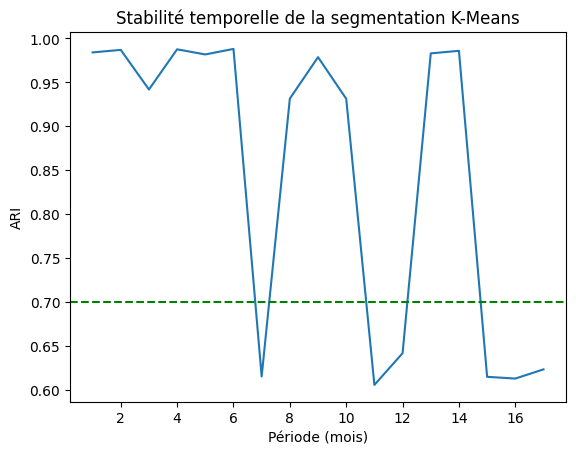

In [24]:
randindex = pd.DataFrame(randindex, columns=["periode","ARI"])
sns.lineplot(data=randindex, x="periode", y="ARI")
plt.axhline(y=0.7, linestyle='--', color='green')
plt.title("Stabilité temporelle de la segmentation K-Means")
plt.xlabel("Période (mois)");

In [25]:
maintenance_period(cpt_m_above)

3.6666666666666665

## Suivi par semaine

In [26]:
nb_week = (commandef - date_init)/np.timedelta64(1,'W')
print(f"il y a {nb_week:.2f} dans le jeu de données (après les 6 premiers mois)")
nb_week = int(nb_week)

il y a 76.02 dans le jeu de données (après les 6 premiers mois)


In [27]:
RandIndexWeek = []
cpt_w_above = []
model_i = kmeans_init
nb_chg_w = 0

for i in range(1,nb_week+1):
    
    date = date_init + np.timedelta64(i,'W')
    df = df_source[df_source["order_purchase_date"]<date]

    df_seg = prepa_feat(df, date)
    
    # les nouvelles données (6 mois + x semaines) sont préprocessées avec le scaler entrainé sur le modèle précédent (le modèle considéré comme étant la "base")
    X_new_old = preprocessing.transform(df_seg) 
    X_new_old = pd.DataFrame(X_new_old, columns=feat_cont + feat_discrete)
    X_new_old.dropna(inplace=True)

    # les nouvelles données (6 mois + x semaines) sont préprocessées avec le scaler entrainé sur son dataset spécifique (6 mois + x semaines)
    X_new_new = prepro_kmeans(feat_cont, feat_discrete, df_seg)
    
    label_old = model_i.predict(X_new_old) # segmentation des nouvelles data (6 mois initial + x mois) à partir du modele entrainé précedemment
    label_new = get_labels(5,X_new_new) # segmentation des nouvelles data (6 mois initial + x mois) à partir du même modèle entrainé sur les données en question

    ri_w = adjusted_rand_score(label_old, label_new)
    RandIndexWeek.append([i,ri_w])

    if ri_w >= 0.70:
        cpt_w_above.append(1)

    if ri_w < 0.70:
        # mise à jour du modele de base pour la suite des périodes
        kmeans_new = KMeans(n_clusters=4, init="k-means++", max_iter = 400, n_init='auto', random_state=42)
        kmeans_new.fit(X_new_new)
        model_i = kmeans_new
        # mise à jour du scaler pour la suite des périodes
        preprocessing = ColumnTransformer(transformers=[('scale', MinMaxScaler(), feat_cont)],remainder='passthrough',verbose_feature_names_out=False)
        preprocessing.fit(df_seg)
        # count
        nb_chg_w +=1
        cpt_w_above.append(0)

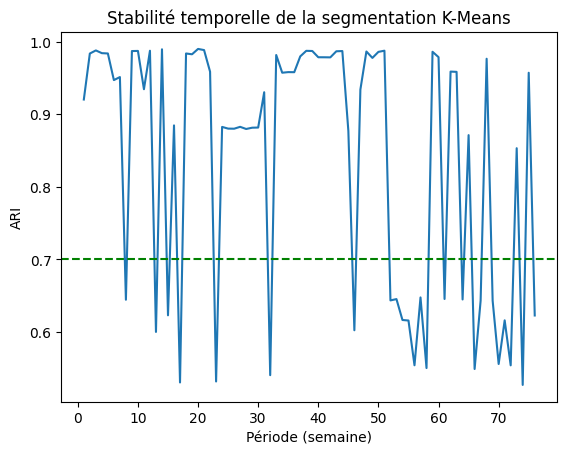

In [28]:
RandIndexWeek = pd.DataFrame(RandIndexWeek, columns=["periode","ARI"])
sns.lineplot(data=RandIndexWeek, x="periode", y="ARI")
plt.axhline(y=0.7, linestyle='--', color='green')
plt.title("Stabilité temporelle de la segmentation K-Means")
plt.xlabel("Période (semaine)");

In [29]:
maintenance_period(cpt_w_above)

3.7142857142857144